# Breakpoint tests

Starting with a known stucture.

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import warnings

In [3]:
from regime_switching.generate.arx import VARXGenerator

In [4]:
import statsmodels.api as sm

## Create two different random models

With the given parameters, the second has only 2 AR lags and more variance.

In [5]:
gen1 = VARXGenerator.random_model(n=1, m=0, p_max=3, p_portion=1, random_state=12)
display(gen1.coef_ar_df)
display(gen1.covariance)

,,0
lag,,
1,0,0.300609
2,0,-0.478138
3,0,0.878121


,0
0,0.202381


In [6]:
gen2 = VARXGenerator.random_model(n=1, m=0, p_max=2, p_portion=1, random_state=14)
display(gen2.coef_ar_df)
display(gen2.covariance)

,,0
lag,,
1,0,0.805642
2,0,-0.487930


,0
0,0.876855


Generate two series, one "full" and one with a structural break

In [7]:
y1 = gen1.generate(100)[0]
y2_end = gen2.generate(50, initial_values=y1.iloc[47:50])[0]
y2 = pd.concat([y1.iloc[:50], y2_end], axis='rows').reset_index(drop=True)

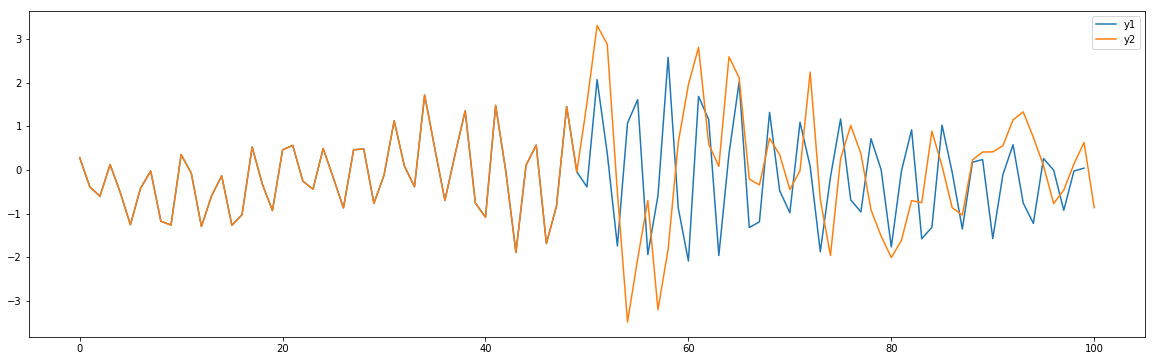

In [8]:
data = pd.DataFrame({
    'y1': y1,
    'y2': y2,
})
data.plot(figsize=(20, 6));

## Detect break

Fit AR models, check log likelihood

In [9]:
m1_full = sm.tsa.AR(y1).fit(maxlag=3)
m1_full.llf

-43.79577468727525

In [10]:
m1_a = sm.tsa.AR(y1.iloc[:50]).fit(maxlag=3)
m1_b = sm.tsa.AR(y1.iloc[50:]).fit(maxlag=3)
m1_a.llf, m1_b.llf

(-19.11601697888115, -13.442739576767513)

In [11]:
m2_a = sm.tsa.AR(y2.iloc[:50]).fit(maxlag=3)
m2_b = sm.tsa.AR(y2.iloc[50:]).fit(maxlag=3)
m2_a.llf, m2_b.llf

(-19.11601697888115, -69.20049083707295)

In [12]:
pd.concat([m2_a.params, m2_b.params], axis='columns')

,0,1
const,-0.036125,-0.076579
L1.y,0.413101,0.788286
L2.y,-0.533458,-0.605129
L3.y,0.897230,0.284595


### Fit models iteratively, switching over at time T, and select the most likely pair

In [13]:
joint_llfs = []
idx = pd.RangeIndex(20, 80)
for T in idx:
    m2_aT = sm.tsa.AR(y2.iloc[:T]).fit(maxlag=3)
    m2_bT = sm.tsa.AR(y2.iloc[T:]).fit(maxlag=3)  # technically this should be 2
    joint_llfs.append(m2_aT.llf + m2_bT.llf)
joint_llfs = pd.Series(joint_llfs, idx)

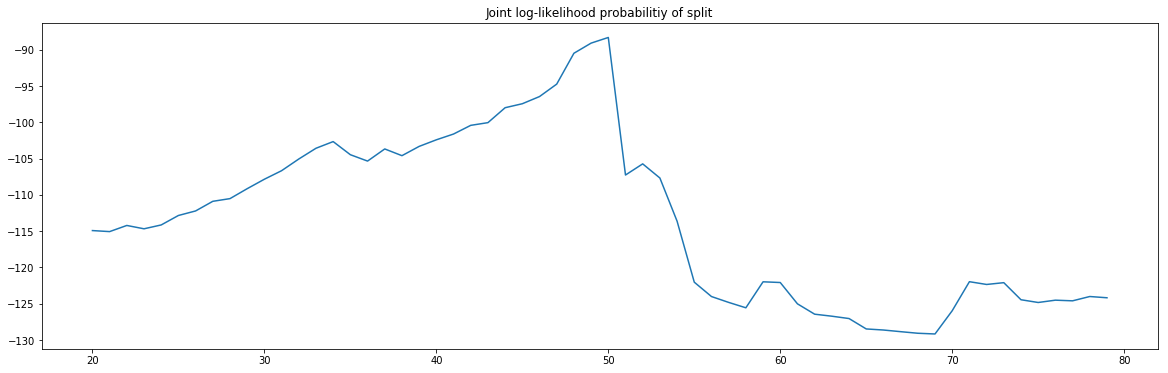

In [14]:
plt.title('Joint log-likelihood probabilitiy of split')
joint_llfs.plot(figsize=(20, 6));

In [15]:
joint_llfs.idxmax()

50

We hit the target directly. :)